## Validate the data (tables) stored in Amazon S3.

In [39]:
import configparser
import os
from datetime import datetime

#import logging
#import boto3
#from botocore.exceptions import ClientError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkContext

from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format

from pyspark.sql.types import StringType, IntegerType, TimestampType, DateType

from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as f

from pyspark.sql import SQLContext

## Read from the AWS credentials from config file

In [2]:
config = configparser.ConfigParser()
config.read('dl.cfg')

['dl.cfg']

In [3]:
os.environ['AWS_ACCESS_KEY_ID']= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']= config['AWS']['AWS_SECRET_ACCESS_KEY']

KEY= config['AWS']['AWS_ACCESS_KEY_ID']
SECRET= config['AWS']['AWS_SECRET_ACCESS_KEY']

In [4]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()
    return spark

In [5]:
spark = create_spark_session()

In [6]:
spark

## Read the data from S3 bucket

In [7]:
output = "s3a://desh1gvrk/parquet"
input =  "s3a://udacity-dend/"

## Validate the records for a given year and month (songplays fact table partition) to the log data.

<font color='red'><b>***** Complete this validation *****</b></font>

### Read the Songplays fact dimension table

In [8]:
songplays = output + '/songplays'
songplays_df = spark.read.parquet(songplays)
tot_fact_records = songplays_df.count()

In [9]:
print("Number of records in Fact Table: {}".format(tot_fact_records))

Number of records in Fact Table: 6820


## Find the most popular song in the yearm

### Filter all the records which have Non NULL song_id

In [12]:
fact_songNN = songplays_df.filter(songplays_df.song_id.isNotNull())

### Create View of the Fact Table

In [13]:
fact_songNN.createOrReplaceTempView('fact_songNN')

### Create View of the songs dimension (Output) table

In [29]:
songs = spark.read.parquet(output + '/songs')

In [30]:
songs.createOrReplaceTempView('songs')

In [120]:
df = spark.sql("SELECT s.song_id, title, COUNT \
                FROM \
                (SELECT song_id, count(1) as COUNT \
                 FROM fact_songNN f GROUP BY song_id) A \
                LEFT JOIN songs s \
                ON s.song_id = A.song_id")

In [121]:
result_df = df.select("*").toPandas()

In [36]:
%matplotlib inline

In [145]:
plt.rcParams.update({'font.size': 22})

In [142]:
def plot(y_pos, performance, objects, l, b, clr, out):
    fig= plt.figure(figsize=(l, b))
    plt.barh(y_pos, performance, align='center', alpha=0.7, color = clr)
    plt.yticks(y_pos, objects)

    plt.xlabel('Count of Songs')
    plt.title('No of songs played in 11/2018')
    
    plt.savefig(out)
    plt.show()

In [122]:
result_df

,song_id,title,COUNT
0,SODOLVO12B0B80B2F4,Hell,1
1,SOFVOQL12A6D4F7456,The Boy With The Thorn In His Side,2
2,SOXQYSC12A6310E908,Bitter Sweet Symphony,2
3,SODWXQV12A6310F10D,English Summer Rain,1
4,SOZCTXZ12AB0182364,Setanta matins,1
5,SOCHRXB12A8AE48069,Let's Get It Started,3
6,SONQBUB12A6D4F8ED0,Angie (1993 Digital Remaster),2
7,SOAOJYY12A58A7B2F9,Not For You,1
8,SOLRYQR12A670215BF,Panama (Remastered Album Version),1
9,SOVWWJW12A670206BE,Astrud Astronette,1


In [137]:
objects_p1 = result_df['title'].tolist()
y_pos_p1 = np.arange(len(objects_p1))
performance_p1 = (result_df['COUNT']*10).tolist()
clr_p1 = ['green' if p == max(performance_p1) else 'grey' for p in performance_p1]

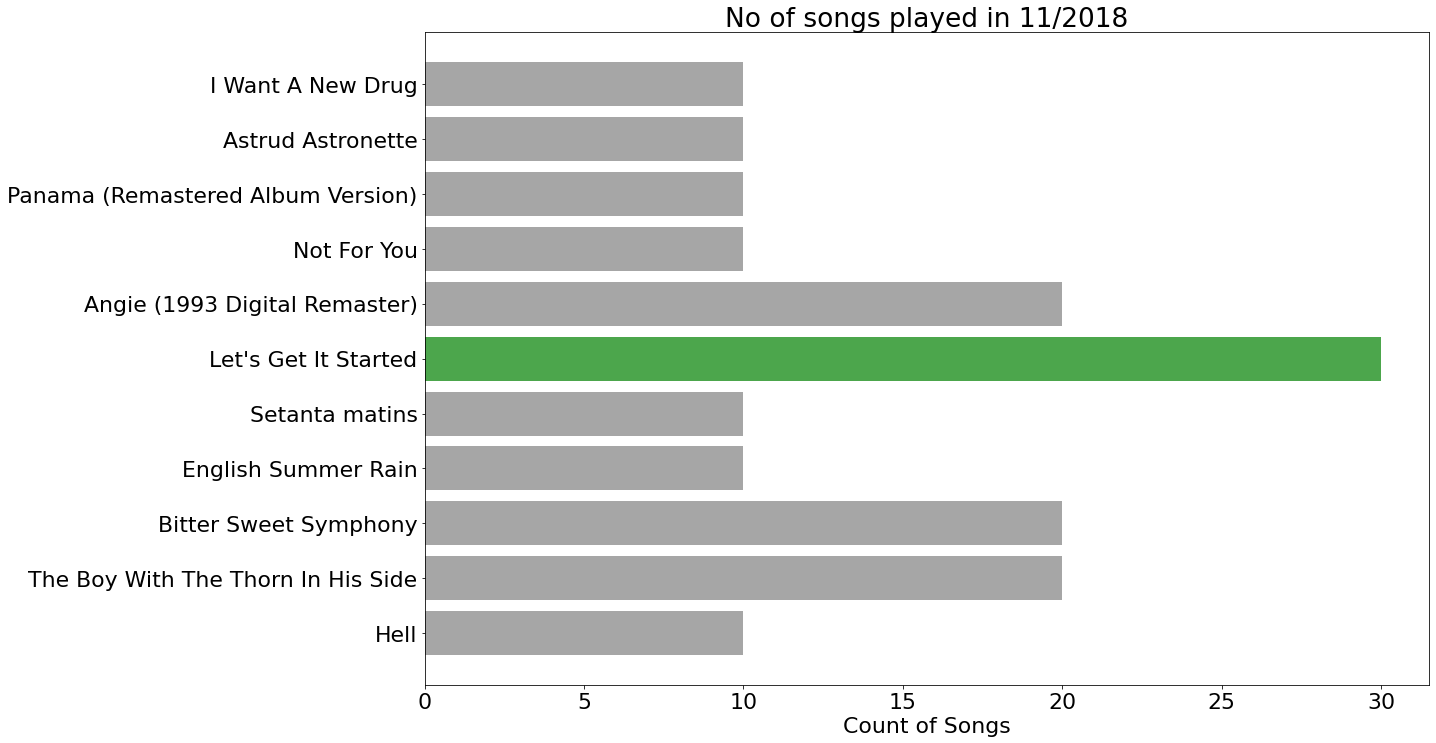

In [146]:
# Bar Graph
plot(y_pos_p1, performance_p1, objects_p1, 18, 12, clr_p1, "p1")

## Find the number of songs in the different years

In [91]:
df = spark.sql("SELECT year, COUNT(*) as COUNT FROM songs GROUP BY year")

In [92]:
result_df = df.select("*").toPandas()

In [94]:
def colors(p):
    if p == max(performance):
        return 'green'
    elif p == min(performance):
        return "red"
    else:
        return 'grey'

In [110]:
objects_p2 = result_df['year'].tolist()
y_pos_p2 = np.arange(len(objects))
performance_p2 = (result_df['COUNT']).tolist()
clr_p2 = [colors(p) for p in performance]

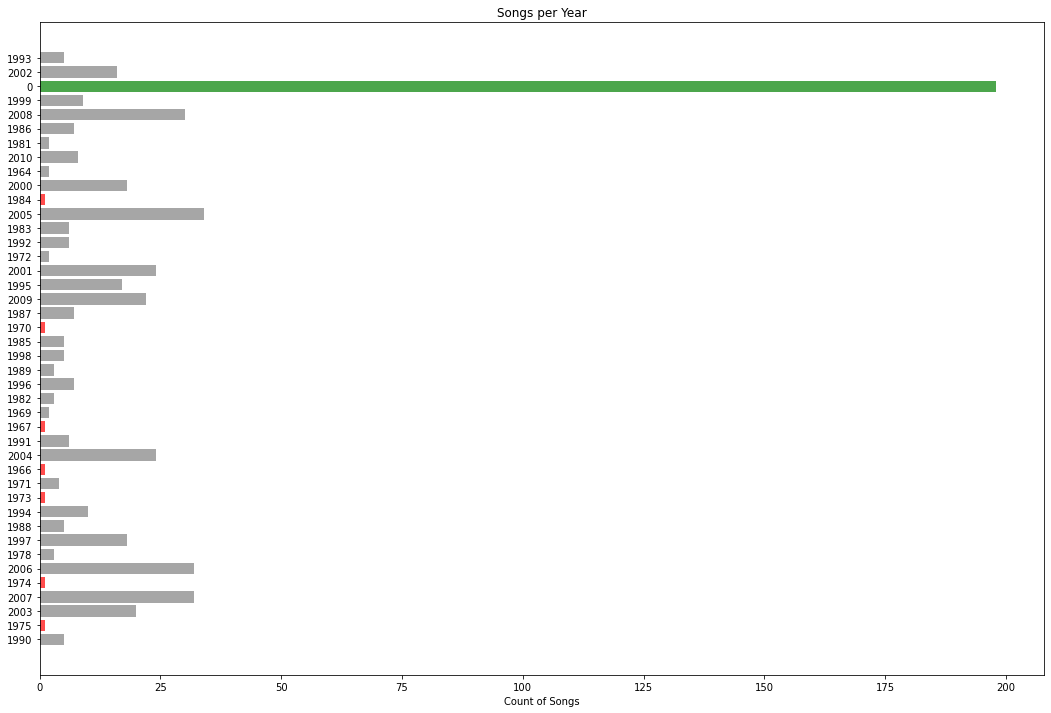

In [119]:
# Bar Graph
plot(y_pos_p2, performance_p2, 18, 12, clr_p2, "p2")